# Computer Vision Pokédex

## Introduction

Insert problem statement and purpose explanation here

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras import Input, layers, Model, models
from keras.applications import *
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
import keras_tuner as kt

from sklearn.metrics import classification_report, confusion_matrix, f1_score, top_k_accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

## Dataset

Insert sources of data and initial cleaning/processing steps taken here

In [2]:
DATA_DIR_NAME = 'data'

class_names = os.listdir(DATA_DIR_NAME)
class_names.sort()
num_classes = len(class_names)
class_names[:10]

['Abra',
 'Aerodactyl',
 'Alakazam',
 'Arbok',
 'Arcanine',
 'Articuno',
 'Beedrill',
 'Bellsprout',
 'Blastoise',
 'Bulbasaur']

In [3]:
image_paths = []
labels = []
for class_name in class_names:
    pokemon_dir = os.path.join(DATA_DIR_NAME, class_name)
    image_file_names = os.listdir(pokemon_dir)
    image_paths.extend(os.path.join(pokemon_dir, name) for name in image_file_names)
    labels.extend([class_name] * len(image_file_names))

df = pd.DataFrame({'filename': image_paths, 'class': labels})

# Sort dataframe so that train-validation-test split is deterministic and reproducible
df.sort_values(by='filename', inplace=True, ignore_index=True)

In [4]:
counts = df.value_counts('class')
counts

class
Pikachu      286
Charizard    167
Venusaur     162
Sandslash    142
Gengar       140
            ... 
Poliwrath     61
Nidoking      60
Dratini       57
Nidoran♂      50
Nidoran♀      44
Name: count, Length: 151, dtype: int64

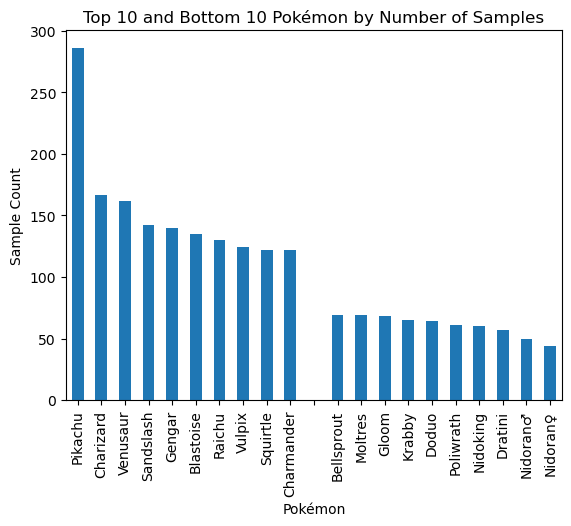

In [5]:
extreme_counts = pd.concat([counts.head(10), pd.Series([0], ['']), counts.tail(10)])
extreme_counts.plot.bar(xlabel="Pokémon", ylabel="Sample Count", title="Top 10 and Bottom 10 Pokémon by Number of Samples")
plt.show()

In [6]:
random_seed = 42

# 60:20:20 train-validation-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=random_seed,
    shuffle=True,
    stratify=df['class']  # Ensure all pokemon represented in each split
)
train_df, validation_df = train_test_split(
    train_df,
    test_size=0.25,
    random_state=random_seed,
    shuffle=True,
    stratify=train_df['class']
)

In [7]:
# Display images in a grid format
def display_images(image_paths, captions, image_size, cols, figsize=(8, 8)):
    rows = (len(image_paths) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.ravel()
    for ax in axs:
        ax.axis('off')
    for ax, image_path, caption in zip(axs, image_paths, captions):
        image = load_img(image_path, target_size=image_size)
        ax.set_title(caption)
        ax.imshow(image)

    plt.show()

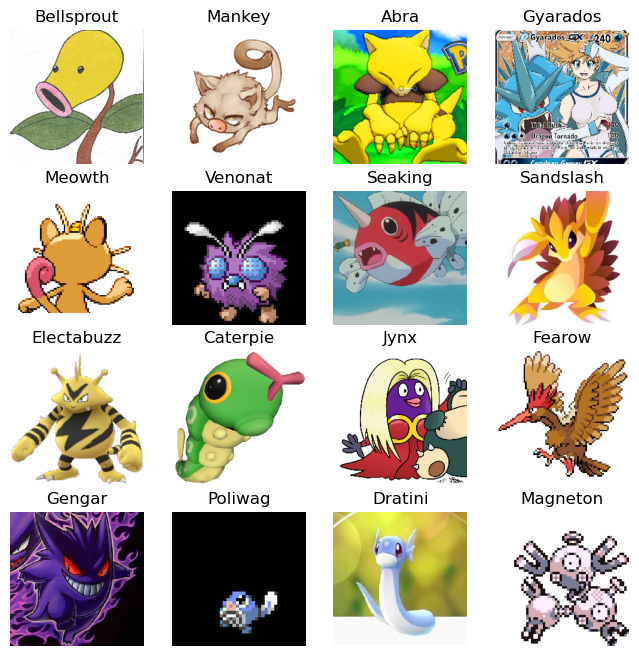

In [8]:
sample_images = train_df[:16]
display_images(sample_images['filename'], sample_images['class'], (224, 224), 4)

## Training

Here might be a good place to give a high level overview of what we are going to do - explain that transfer learning is our main strategy and what that is

### Utilities

In [9]:
# Makes a generator which yields mini-batches of images with optional live data augmentation
def make_image_generator(dataframe, image_size, preprocessing_function, batch_size=64, shuffle=True, **augmentations):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        **augmentations
    )
    return datagen.flow_from_dataframe(
        dataframe,
        target_size=image_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle
    )

In [10]:
# Makes image generators using the training and validation data
def make_training_generators(image_size, preprocessing_function, batch_size=64, **augmentations):
    train_generator = make_image_generator(train_df, image_size, preprocessing_function, batch_size, **augmentations)
    validation_generator = make_image_generator(validation_df, image_size, preprocessing_function, batch_size)
    return train_generator, validation_generator

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

### Baseline Model

Talk about choice of baseline model here

In [12]:
# Note: preprocessing functions provided by Keras help adjust pixel values
# by centering/scaling/normalizing in the way the base model expects
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=vgg16.preprocess_input
)

In [13]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base_model.trainable = False

vgg16_model = models.Sequential([
    vgg16_base_model,
    layers.Flatten(input_shape=vgg16_base_model.output_shape[1:]),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

vgg16_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

58889256/58889256 [==============================] - 4s 0us/step


In [14]:
vgg16_history = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
131/131 [==============================] - 120s 845ms/step - loss: 32.1150 - accuracy: 0.3169 - val_loss: 2.5789 - val_accuracy: 0.4876
Epoch 2/50
131/131 [==============================] - 96s 732ms/step - loss: 0.7755 - accuracy: 0.8289 - val_loss: 2.5151 - val_accuracy: 0.5736
Epoch 3/50
131/131 [==============================] - 111s 853ms/step - loss: 0.2888 - accuracy: 0.9440 - val_loss: 2.6786 - val_accuracy: 0.5994
Epoch 4/50
131/131 [==============================] - 110s 841ms/step - loss: 0.2183 - accuracy: 0.9678 - val_loss: 3.0162 - val_accuracy: 0.5958
Epoch 5/50
131/131 [==============================] - 91s 696ms/step - loss: 0.4199 - accuracy: 0.9578 - val_loss: 3.7962 - val_accuracy: 0.5718
Epoch 6/50
131/131 [==============================] - 91s 693ms/step - loss: 0.4916 - accuracy: 0.9221 - val_loss: 4.6065 - val_accuracy: 0.5693
Epoch 7/50
131/131 [==============================] - 91s 691ms/step - loss: 0.6977 - accuracy: 0.9033 - val_loss: 6.4044 - va

In [15]:
vgg16_model.save('models/model_baseline.tf')
with open('histories/baseline_model_training.pkl', 'wb') as file:
    pickle.dump(vgg16_history.history, file)

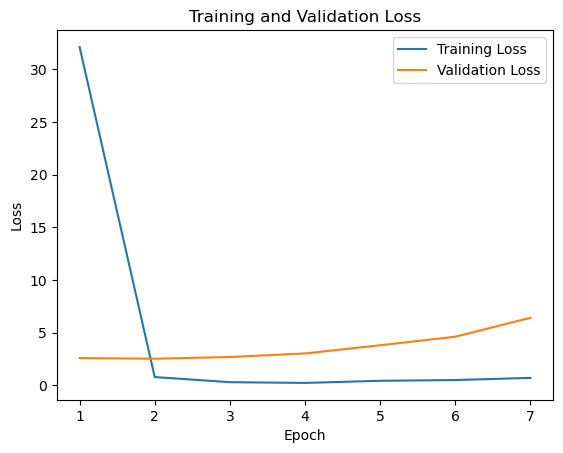

In [16]:
x_range = range(1, len(vgg16_history.history['loss']) + 1)

plt.figure()
plt.plot(x_range, vgg16_history.history['loss'], label='Training Loss')
plt.plot(x_range, vgg16_history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x_range)
plt.legend()
plt.show()

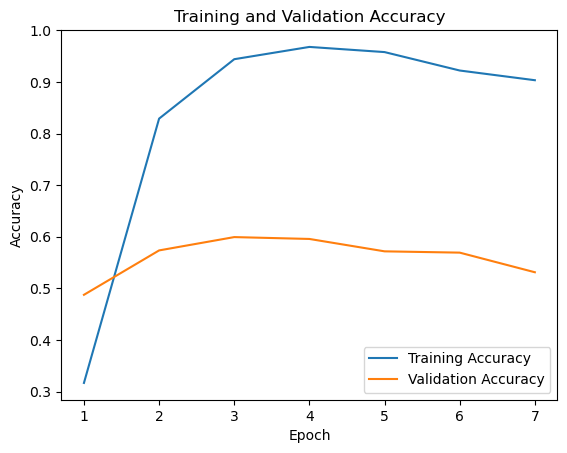

In [17]:
plt.figure()
plt.plot(x_range, vgg16_history.history['accuracy'], label='Training Accuracy')
plt.plot(x_range, vgg16_history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(x_range)
plt.legend()
plt.show()

### Experimenting with Various Models

Explain models tried. Mention somewhere that bigger models seem to perform better and why. Explain that we chose densenet in the end because lowest val_loss, highest val_acc. Can also mention that it trains faster than efficientnet, so it helps us experiment witwith different ideas faster

In [18]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=resnet.preprocess_input
)

resnet_base_model = ResNet152(weights='imagenet', include_top=False)
resnet_base_model.trainable = False

resnet_model = models.Sequential([
    resnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
234698864/234698864 [==============================] - 7s 0us/step


In [19]:
resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 [==============================] - 124s 841ms/step - loss: 2.9245 - accuracy: 0.4052 - val_loss: 1.5775 - val_accuracy: 0.6466
Epoch 2/10
131/131 [==============================] - 108s 824ms/step - loss: 0.8536 - accuracy: 0.8160 - val_loss: 1.2093 - val_accuracy: 0.7161
Epoch 3/10
131/131 [==============================] - 105s 800ms/step - loss: 0.4525 - accuracy: 0.9203 - val_loss: 1.0070 - val_accuracy: 0.7633
Epoch 4/10
131/131 [==============================] - 122s 928ms/step - loss: 0.2732 - accuracy: 0.9622 - val_loss: 0.9331 - val_accuracy: 0.7820
Epoch 5/10
131/131 [==============================] - 104s 793ms/step - loss: 0.1752 - accuracy: 0.9851 - val_loss: 0.8932 - val_accuracy: 0.7863
Epoch 6/10
131/131 [==============================] - 107s 814ms/step - loss: 0.1209 - accuracy: 0.9912 - val_loss: 0.8762 - val_accuracy: 0.7916
Epoch 7/10
131/131 [==============================] - 121s 924ms/step - loss: 0.0875 - accuracy: 0.9947 - val_loss: 0.8597 -

In [20]:
train_generator, validation_generator = make_training_generators(
    image_size=(299, 299),
    preprocessing_function=inception_v3.preprocess_input
)

inception_v3_base_model = InceptionV3(weights='imagenet', include_top=False)
inception_v3_base_model.trainable = False

inception_v3_model = models.Sequential([
    inception_v3_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

inception_v3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
87910968/87910968 [==============================] - 3s 0us/step


In [21]:
inception_v3_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 [==============================] - 130s 921ms/step - loss: 4.1180 - accuracy: 0.1839 - val_loss: 3.1827 - val_accuracy: 0.3974
Epoch 2/10
131/131 [==============================] - 103s 786ms/step - loss: 2.3841 - accuracy: 0.5435 - val_loss: 2.3950 - val_accuracy: 0.5066
Epoch 3/10
131/131 [==============================] - 116s 884ms/step - loss: 1.6560 - accuracy: 0.6958 - val_loss: 2.0930 - val_accuracy: 0.5550
Epoch 4/10
131/131 [==============================] - 116s 884ms/step - loss: 1.2562 - accuracy: 0.7772 - val_loss: 1.8617 - val_accuracy: 0.6019
Epoch 5/10
131/131 [==============================] - 118s 900ms/step - loss: 0.9921 - accuracy: 0.8351 - val_loss: 1.7107 - val_accuracy: 0.6226
Epoch 6/10
131/131 [==============================] - 104s 789ms/step - loss: 0.8081 - accuracy: 0.8730 - val_loss: 1.6618 - val_accuracy: 0.6276
Epoch 7/10
131/131 [==============================] - 102s 777ms/step - loss: 0.6661 - accuracy: 0.9064 - val_loss: 1.5759 -

In [22]:
train_generator, validation_generator = make_training_generators(
    image_size=(299, 299),
    preprocessing_function=inception_resnet_v2.preprocess_input
)

inception_resnet_base_model = InceptionResNetV2(weights='imagenet', include_top=False)
inception_resnet_base_model.trainable = False

inception_resnet_model = models.Sequential([
    inception_resnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

inception_resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
219055592/219055592 [==============================] - 7s 0us/step


In [23]:
inception_resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 [==============================] - 142s 972ms/step - loss: 4.2584 - accuracy: 0.1621 - val_loss: 3.3941 - val_accuracy: 0.3358
Epoch 2/10
131/131 [==============================] - 128s 978ms/step - loss: 2.7460 - accuracy: 0.4614 - val_loss: 2.6472 - val_accuracy: 0.4637
Epoch 3/10
131/131 [==============================] - 119s 906ms/step - loss: 2.0701 - accuracy: 0.6094 - val_loss: 2.2535 - val_accuracy: 0.5353
Epoch 4/10
131/131 [==============================] - 137s 1s/step - loss: 1.6751 - accuracy: 0.6870 - val_loss: 2.0193 - val_accuracy: 0.5782
Epoch 5/10
131/131 [==============================] - 128s 972ms/step - loss: 1.4158 - accuracy: 0.7430 - val_loss: 1.8748 - val_accuracy: 0.6087
Epoch 6/10
131/131 [==============================] - 116s 882ms/step - loss: 1.2294 - accuracy: 0.7797 - val_loss: 1.7541 - val_accuracy: 0.6305
Epoch 7/10
131/131 [==============================] - 114s 871ms/step - loss: 1.0764 - accuracy: 0.8130 - val_loss: 1.6976 - va

In [24]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
74836368/74836368 [==============================] - 3s 0us/step


In [25]:
densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 [==============================] - 152s 984ms/step - loss: 3.7086 - accuracy: 0.2825 - val_loss: 2.4595 - val_accuracy: 0.5424
Epoch 2/10
131/131 [==============================] - 96s 734ms/step - loss: 1.6154 - accuracy: 0.7427 - val_loss: 1.5976 - val_accuracy: 0.7014
Epoch 3/10
131/131 [==============================] - 98s 749ms/step - loss: 0.9692 - accuracy: 0.8531 - val_loss: 1.2716 - val_accuracy: 0.7537
Epoch 4/10
131/131 [==============================] - 96s 734ms/step - loss: 0.6648 - accuracy: 0.9101 - val_loss: 1.1127 - val_accuracy: 0.7723
Epoch 5/10
131/131 [==============================] - 96s 733ms/step - loss: 0.4897 - accuracy: 0.9419 - val_loss: 1.0093 - val_accuracy: 0.7880
Epoch 6/10
131/131 [==============================] - 94s 713ms/step - loss: 0.3771 - accuracy: 0.9603 - val_loss: 0.9414 - val_accuracy: 0.8042
Epoch 7/10
131/131 [==============================] - 97s 743ms/step - loss: 0.2927 - accuracy: 0.9743 - val_loss: 0.8893 - val_a

In [26]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=efficientnet.preprocess_input
)

efficientnet_base_model = EfficientNetB7(weights='imagenet', include_top=False)
efficientnet_base_model.trainable = False

efficientnet_model = models.Sequential([
    efficientnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
258076736/258076736 [==============================] - 8s 0us/step


In [27]:
efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
131/131 [==============================] - 167s 1s/step - loss: 3.2568 - accuracy: 0.4152 - val_loss: 2.0174 - val_accuracy: 0.6724
Epoch 2/10
131/131 [==============================] - 125s 952ms/step - loss: 1.4817 - accuracy: 0.7606 - val_loss: 1.3981 - val_accuracy: 0.7504
Epoch 3/10
131/131 [==============================] - 124s 948ms/step - loss: 0.9914 - accuracy: 0.8379 - val_loss: 1.1662 - val_accuracy: 0.7726
Epoch 4/10
131/131 [==============================] - 125s 952ms/step - loss: 0.7348 - accuracy: 0.8850 - val_loss: 1.0444 - val_accuracy: 0.7863
Epoch 5/10
131/131 [==============================] - 134s 1s/step - loss: 0.5800 - accuracy: 0.9160 - val_loss: 0.9666 - val_accuracy: 0.8038
Epoch 6/10
131/131 [==============================] - 124s 944ms/step - loss: 0.4762 - accuracy: 0.9327 - val_loss: 0.9199 - val_accuracy: 0.8059
Epoch 7/10
131/131 [==============================] - 135s 1s/step - loss: 0.3931 - accuracy: 0.9493 - val_loss: 0.8896 - val_accu

### Data Augmentation

Explain what (live) data augmentation is and why we doing it. Explain how we choose augmentations. Compare results with and without

In [28]:
def make_augmented_dataset():
    return make_training_generators(
        image_size=(224, 224),
        preprocessing_function=densenet.preprocess_input,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.8, 1.2),
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

In [29]:
# Without data augmentations
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [30]:
hist1 = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
131/131 [==============================] - 143s 905ms/step - loss: 3.7243 - accuracy: 0.2733 - val_loss: 2.4134 - val_accuracy: 0.5521
Epoch 2/20
131/131 [==============================] - 100s 767ms/step - loss: 1.6296 - accuracy: 0.7310 - val_loss: 1.5424 - val_accuracy: 0.7182
Epoch 3/20
131/131 [==============================] - 97s 738ms/step - loss: 0.9817 - accuracy: 0.8515 - val_loss: 1.2304 - val_accuracy: 0.7526
Epoch 4/20
131/131 [==============================] - 113s 861ms/step - loss: 0.6755 - accuracy: 0.9089 - val_loss: 1.0732 - val_accuracy: 0.7834
Epoch 5/20
131/131 [==============================] - 95s 721ms/step - loss: 0.4989 - accuracy: 0.9404 - val_loss: 0.9815 - val_accuracy: 0.7898
Epoch 6/20
131/131 [==============================] - 100s 764ms/step - loss: 0.3788 - accuracy: 0.9588 - val_loss: 0.9035 - val_accuracy: 0.8088
Epoch 7/20
131/131 [==============================] - 99s 754ms/step - loss: 0.2954 - accuracy: 0.9745 - val_loss: 0.8649 - va

In [31]:
with open('histories/training_no_augmentation.pkl', 'wb') as file:
    pickle.dump(hist1.history, file)

In [32]:
# With live data augmentations
train_generator, validation_generator = make_augmented_dataset()

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
    densenet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [33]:
hist2 = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
131/131 [==============================] - 240s 2s/step - loss: 3.9311 - accuracy: 0.2275 - val_loss: 2.6041 - val_accuracy: 0.5109
Epoch 2/20
131/131 [==============================] - 219s 2s/step - loss: 2.0228 - accuracy: 0.6287 - val_loss: 1.7165 - val_accuracy: 0.6667
Epoch 3/20
131/131 [==============================] - 225s 2s/step - loss: 1.3439 - accuracy: 0.7605 - val_loss: 1.3493 - val_accuracy: 0.7322
Epoch 4/20
131/131 [==============================] - 221s 2s/step - loss: 1.0217 - accuracy: 0.8153 - val_loss: 1.1556 - val_accuracy: 0.7587
Epoch 5/20
131/131 [==============================] - 220s 2s/step - loss: 0.8126 - accuracy: 0.8563 - val_loss: 1.0545 - val_accuracy: 0.7673
Epoch 6/20
131/131 [==============================] - 223s 2s/step - loss: 0.6865 - accuracy: 0.8773 - val_loss: 0.9736 - val_accuracy: 0.7798
Epoch 7/20
131/131 [==============================] - 220s 2s/step - loss: 0.5897 - accuracy: 0.8975 - val_loss: 0.9278 - val_accuracy: 0.7891

In [34]:
with open('histories/training_with_augmentation.pkl', 'wb') as file:
    pickle.dump(hist2.history, file)

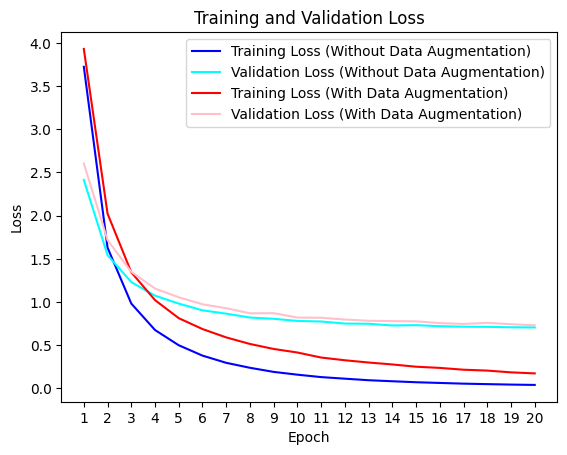

In [35]:
x_range = range(1, 21)

plt.figure()
plt.plot(x_range, hist1.history['loss'], label='Training Loss (Without Data Augmentation)', color='blue')
plt.plot(x_range, hist1.history['val_loss'], label='Validation Loss (Without Data Augmentation)', color='cyan')
plt.plot(x_range, hist2.history['loss'], label='Training Loss (With Data Augmentation)', color='red')
plt.plot(x_range, hist2.history['val_loss'], label='Validation Loss (With Data Augmentation)', color='pink')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(x_range)
plt.legend()
plt.show()

### Hyperparameter Tuning for Classification Head

Explain that we trying out different things on top of model (classification head), and what turned out best

In [36]:
train_generator, validation_generator = make_augmented_dataset()
densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

In [37]:
def build_model(hp):
    dropout = hp.Choice('dropout', values=[0.0, 0.25, 0.5])
    model = models.Sequential()
    model.add(densenet_base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(dropout))
    for i in range(hp.Int('num_layers', 0, 2)):
        model.add(layers.Dense(1024 // (2 ** i), activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    return model

In [38]:
tuner = kt.tuners.GridSearch(
    build_model,
    objective='val_accuracy',
    directory='tuner',
    project_name='pokedex'
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': 'linear'}


In [39]:
tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[early_stopping]
)

tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Pokedex/tuner/pokedex
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0003 summary
Hyperparameters:
dropout: 0.25
num_layers: 0
Score: 0.8148943781852722

Trial 0000 summary
Hyperparameters:
dropout: 0.0
num_layers: 0
Score: 0.8088077306747437

Trial 0006 summary
Hyperparameters:
dropout: 0.5
num_layers: 0
Score: 0.7973505258560181

Trial 0004 summary
Hyperparameters:
dropout: 0.25
num_layers: 1
Score: 0.795918345451355

Trial 0001 summary
Hyperparameters:
dropout: 0.0
num_layers: 1
Score: 0.7780164480209351

Trial 0005 summary
Hyperparameters:
dropout: 0.25
num_layers: 2
Score: 0.7629788517951965

Trial 0007 summary
Hyperparameters:
dropout: 0.5
num_layers: 1
Score: 0.7608306407928467

Trial 0002 summary
Hyperparameters:
dropout: 0.0
num_layers: 2
Score: 0.7601145505905151

Trial 0008 summary
Hyperparameters:
dropout: 0.5
num_layers: 2
Score: 0.6595059037208557


### Training and Fine-tuning Final Model

Explain transfer learning and fine tuning

In [40]:
train_generator, validation_generator = make_augmented_dataset()

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False
inputs = Input(shape=(224, 224, 3))
x = densenet_base_model(inputs, training=False)  # Ensure batchnorm layers run in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_train = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
Epoch 1/50
131/131 [==============================] - 248s 2s/step - loss: 4.2727 - accuracy: 0.1524 - val_loss: 2.8396 - val_accuracy: 0.4429
Epoch 2/50
131/131 [==============================] - 217s 2s/step - loss: 2.4198 - accuracy: 0.5017 - val_loss: 1.8773 - val_accuracy: 0.6380
Epoch 3/50
131/131 [==============================] - 213s 2s/step - loss: 1.6777 - accuracy: 0.6580 - val_loss: 1.4770 - val_accuracy: 0.6950
Epoch 4/50
131/131 [==============================] - 214s 2s/step - loss: 1.3308 - accuracy: 0.7294 - val_loss: 1.2579 - val_accuracy: 0.7454
Epoch 5/50
131/131 [==============================] - 217s 2s/step - loss: 1.1055 - accuracy: 0.7687 - val_loss: 1.1370 - val_accuracy: 0.7544
Epoch 6/50
131/131 [==============================] - 215s 2s/step - loss: 0.9700 - accuracy: 0.7929 - val_loss: 1.0394 - val_accuracy: 0.7752
Epoch 7/50
131/1

In [41]:
model.save('models/model_untuned.tf')
with open('histories/model_training.pkl', 'wb') as file:
    pickle.dump(history_train.history, file)

In [42]:
NUM_LAYERS_TO_UNFREEZE = 100

for layer in densenet_base_model.layers[-NUM_LAYERS_TO_UNFREEZE:]:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-5),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
131/131 [==============================] - 229s 2s/step - loss: 0.3403 - accuracy: 0.9163 - val_loss: 0.7185 - val_accuracy: 0.8185
Epoch 2/30
131/131 [==============================] - 200s 2s/step - loss: 0.3391 - accuracy: 0.9173 - val_loss: 0.7104 - val_accuracy: 0.8213
Epoch 3/30
131/131 [==============================] - 199s 2s/step - loss: 0.3291 - accuracy: 0.9187 - val_loss: 0.7050 - val_accuracy: 0.8228
Epoch 4/30
131/131 [==============================] - 203s 2s/step - loss: 0.3257 - accuracy: 0.9198 - val_loss: 0.7022 - val_accuracy: 0.8246
Epoch 5/30
131/131 [==============================] - 201s 2s/step - loss: 0.3259 - accuracy: 0.9235 - val_loss: 0.7002 - val_accuracy: 0.8238
Epoch 6/30
131/131 [==============================] - 199s 2s/step - loss: 0.3173 - accuracy: 0.9208 - val_loss: 0.6992 - val_accuracy: 0.8249
Epoch 7/30
131/131 [==============================] - 202s 2s/step - loss: 0.3287 - accuracy: 0.9193 - val_loss: 0.6982 - val_accuracy: 0.8256

In [43]:
model.save('models/model_final.tf')
with open('histories/final_model_tuning.pkl', 'wb') as file:
    pickle.dump(history_fine.history, file)

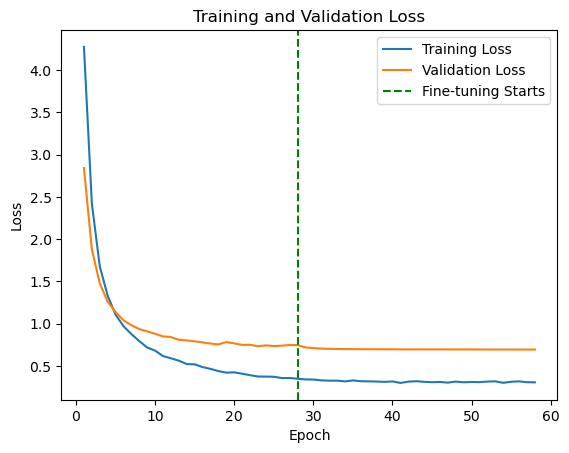

In [44]:
loss_history = history_train.history['loss'] + history_fine.history['loss']
val_loss_history = history_train.history['val_loss'] + history_fine.history['val_loss']

num_train_epochs = len(history_train.history['loss'])
x_range = range(1, len(loss_history) + 1)

plt.figure()
plt.plot(x_range, loss_history, label='Training Loss')
plt.plot(x_range, val_loss_history, label='Validation Loss')
plt.axvline(num_train_epochs, label='Fine-tuning Starts', color='green', linestyle='--')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

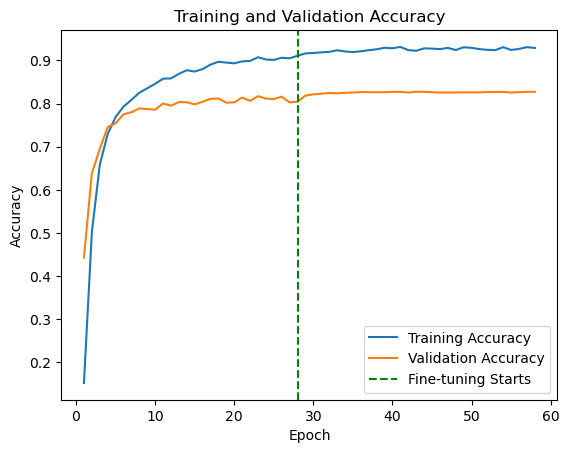

In [45]:
acc_history = history_train.history['accuracy'] + history_fine.history['accuracy']
val_acc_history = history_train.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure()
plt.plot(x_range, acc_history, label='Training Accuracy')
plt.plot(x_range, val_acc_history, label='Validation Accuracy')
plt.axvline(num_train_epochs, label='Fine-tuning Starts', color='green', linestyle='--')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Analysis of Results

Discuss results and stuff, add more cells as necessary to explain each bit

In [46]:
baseline_model = models.load_model('models/model_baseline.tf')
final_model = models.load_model('models/model_final.tf')

In [47]:
baseline_model_test_generator = make_image_generator(
    test_df,
    image_size=(224, 224),
    preprocessing_function=vgg16.preprocess_input,
    shuffle=False
)
final_model_test_generator = make_image_generator(
    test_df,
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input,
    shuffle=False
)

Found 2793 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [48]:
baseline_model_loss, baseline_model_acc = baseline_model.evaluate(baseline_model_test_generator)
final_model_loss, final_model_acc = final_model.evaluate(final_model_test_generator)

print(f'Baseline model loss:{baseline_model_loss:.5f}, Baseline model accuracy: {100 * baseline_model_acc:.3f}%')
print(f'Final model loss: {final_model_loss:.5f}, Final model accuracy: {100 * final_model_acc:.3f}%')

44/44 [==============================] - 30s 599ms/step - loss: 0.7335 - accuracy: 0.8142
Baseline model loss:2.64810, Baseline model accuracy: 57.823%
Final model loss: 0.73346, Final model accuracy: 81.418%


In [49]:
baseline_model_probs = baseline_model.predict(baseline_model_test_generator)
final_model_probs = final_model.predict(final_model_test_generator)
actual_labels = final_model_test_generator.classes

k = 3
baseline_model_k_acc = top_k_accuracy_score(actual_labels, baseline_model_probs, k=k)
final_model_k_acc = top_k_accuracy_score(actual_labels, final_model_probs, k=k)

print(f'Baseline model top-{k} accuracy: {100 * baseline_model_k_acc:.3f}%')
print(f'Final model top-{k} accuracy: {100 * final_model_k_acc:.3f}%')

44/44 [==============================] - 38s 797ms/step
Baseline model top-3 accuracy: 69.316%
Final model top-3 accuracy: 91.156%


In [50]:
baseline_pred_labels = np.argmax(baseline_model_probs, axis=-1)
final_pred_labels = np.argmax(final_model_probs, axis=-1)

# Use weighted average to account for class imbalance
baseline_model_f1 = f1_score(actual_labels, baseline_pred_labels, average='weighted')
final_model_f1 = f1_score(actual_labels, final_pred_labels, average='weighted')

print(f'Baseline model weighted average f1 score: {baseline_model_f1:.5f}')
print(f'Final model weighted average f1 score: {final_model_f1:.5f}')

Baseline model weighted average f1 score: 0.58533
Final model weighted average f1 score: 0.81597


In [51]:
print(classification_report(actual_labels, final_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

        Abra       1.00      0.79      0.88        14
  Aerodactyl       0.89      0.80      0.84        20
    Alakazam       0.74      0.78      0.76        18
       Arbok       0.82      0.78      0.80        18
    Arcanine       0.57      0.68      0.62        19
    Articuno       0.92      0.63      0.75        19
    Beedrill       0.94      0.83      0.88        18
  Bellsprout       0.93      1.00      0.97        14
   Blastoise       0.86      0.70      0.78        27
   Bulbasaur       0.81      0.96      0.88        23
  Butterfree       1.00      0.82      0.90        22
    Caterpie       0.94      0.89      0.91        18
     Chansey       0.94      0.89      0.92        19
   Charizard       0.55      0.85      0.67        33
  Charmander       0.77      0.96      0.85        24
  Charmeleon       1.00      0.62      0.76        21
    Clefable       0.94      0.89      0.91        18
    Clefairy       0.89    

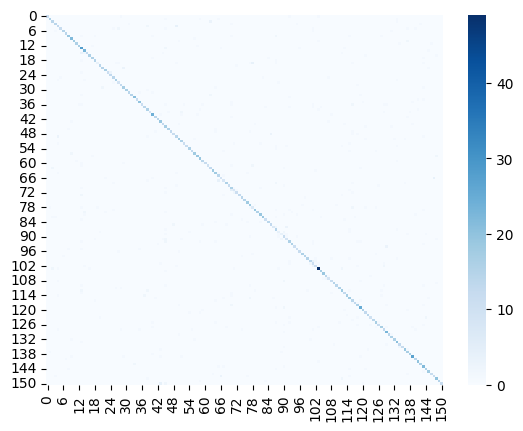

In [52]:
conf_matrix = confusion_matrix(actual_labels, final_pred_labels)
sns.heatmap(conf_matrix, cmap='Blues')
plt.show()

In [53]:
most_common_misclassifications = []

for r, row in enumerate(conf_matrix):
    for c, val in enumerate(row):
        if r != c and val > 0:
            most_common_misclassifications.append((val, r, c))

most_common_misclassifications.sort(reverse=True)

print("Top Misclassifications:")
for count, actual, pred in most_common_misclassifications[:20]:
    print(f"True class {class_names[actual]} misclassified as {class_names[pred]}: Count {count}")

Top Misclassifications:
True class Machoke misclassified as Machamp: Count 5
True class Zubat misclassified as Golbat: Count 4
True class Pidgeot misclassified as Pidgeotto: Count 4
True class Krabby misclassified as Kingler: Count 4
True class Koffing misclassified as Weezing: Count 4
True class Cubone misclassified as Marowak: Count 4
True class Charmeleon misclassified as Charizard: Count 4
True class Arcanine misclassified as Growlithe: Count 4
True class Weezing misclassified as Koffing: Count 3
True class Pidgey misclassified as Pidgeotto: Count 3
True class Omanyte misclassified as Squirtle: Count 3
True class Nidoking misclassified as Nidorino: Count 3
True class Growlithe misclassified as Arcanine: Count 3
True class Grimer misclassified as Muk: Count 3
True class Dodrio misclassified as Doduo: Count 3
True class Diglett misclassified as Dugtrio: Count 3
True class Alakazam misclassified as Kadabra: Count 3
True class Zubat misclassified as Golduck: Count 2
True class Wigglytu

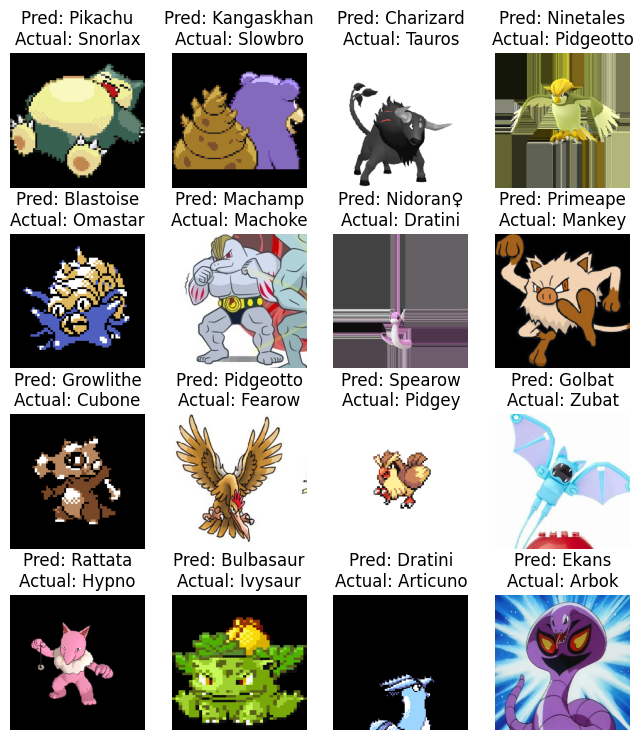

In [54]:
misclassified_image_idxs = [idx for idx, (pred, actual) in enumerate(zip(final_pred_labels, actual_labels)) if pred != actual]
misclassified_images = test_df.iloc[misclassified_image_idxs]
captions = [
    f'Pred: {class_names[final_pred_labels[idx]]}\nActual: {class_names[actual_labels[idx]]}'
    for idx in misclassified_image_idxs
]
display_images(misclassified_images['filename'][:16], captions[:16], (224, 224), 4, figsize=(8, 9))

## Discussion

Talk about strengths, weaknesses, the many many possible ideas for future work

## Conclusion

Delete if unnecessary